# Image generation with Flux.1 and OpenVINO

Flux is a AI image generation model developed by [Black Forest Labs](https://blackforestlabs.ai/our-team/). It represents a significant advancement in AI-generated art, utilizing a hybrid architecture of [multimodal](https://arxiv.org/abs/2403.03206) and [parallel](https://arxiv.org/abs/2302.05442) [diffusion transformer](https://arxiv.org/abs/2212.09748) blocks and scaled to 12B parameter. The model offers state-of-the-art performance image generation with top of the line prompt following, visual quality, image detail and output diversity.More details about model can be found in [blog post](https://blackforestlabs.ai/announcing-black-forest-labs/) and [original repo](https://github.com/black-forest-labs/flux)

<img src="https://raw.githubusercontent.com/black-forest-labs/flux/main/assets/grid.jpg" width="1024" height="800"> 

In this tutorial we consider how to convert and optimized Flux.1 model using OpenVINO.

>**Note**: Some demonstrated models can require at least 32GB RAM for conversion and running.

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Select model](#Select-model)
- [Convert model with OpenVINO](#Convert-model-with-OpenVINO)
- [Compress model weights](#Compress-model-weights)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
- [Interactive demo](#Interactive-demo)



<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/flux.1-image-generation/flux.1-image-generation.ipynb" />

### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
%pip install -q "gradio>=4.19" "torch>=2.1"  "transformers" "nncf>=2.12.0" "diffusers>=0.30.0" "opencv-python" "pillow" "peft>=0.7.0" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "sentencepiece" "protobuf"
%pip install -qU "openvino>=2024.4.0"

In [2]:
import requests
from pathlib import Path

if not Path("flux_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/flux.1-image-generation/flux_helper.py")
    open("flux_helper.py", "w").write(r.text)

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/flux.1-image-generation/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

## Select model
[back to top ⬆️](#Table-of-contents:)

To strike a balance between accessibility and model capabilities, FLUX.1 comes in three variants: FLUX.1-pro, FLUX.1-dev and FLUX.1-schnell: 
* **FLUX.1-pro**: The best of FLUX.1, offering state-of-the-art performance image generation with top of the line prompt following, visual quality, image detail and output diversity, but not available for public usage.
* **FLUX.1-dev**: FLUX.1-dev is an open-weight, guidance-distilled models. Directly distilled from FLUX.1-pro, FLUX.1-dev obtains similar quality and prompt adherence capabilities, while being more efficient than a standard model of the same size. FLUX.1-dev weights are available on [HuggingFace](https://huggingface.co/black-forest-labs/FLUX.1-dev).
* **FLUX.1-schnell**: the fastest model from Flux family is tailored for local development and personal use. FLUX.1-schnell is openly available under an Apache2.0 license. Similar, FLUX.1-dev, weights are available on [HuggingFace](https://huggingface.co/black-forest-labs/FLUX.1-schnell).

![family.png](https://github.com/user-attachments/assets/c7f9df6b-cff3-4d33-98d7-1bb400b2861c)

Be default, we will use FLUX.1-schnell model, but you can switch to FLUX.1-dev version using widget bellow.

In [3]:
from flux_helper import get_model_selector

model_selector = get_model_selector()
model_selector

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


2024-08-13 17:30:13.543036: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 17:30:13.544738: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-13 17:30:13.579013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 17:30:14.449873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Dropdown(description='Model:', options=('black-forest-labs/FLUX.1-schnell', 'black-forest-labs/FLUX.1-dev'), v…

>**Note**: run Flux.1-dev model with notebook, you will need to accept license agreement. 
>You must be a registered user in 🤗 Hugging Face Hub. Please visit [HuggingFace model card](https://huggingface.co/black-forest-labs/FLUX.1-dev), carefully read terms of usage and click accept button.  You will need to use an access token for the code below to run. For more information on access tokens, refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).
>You can login on Hugging Face Hub in notebook environment, using following code:

In [4]:
# uncomment these lines to login to huggingfacehub to get access to pretrained model

# from huggingface_hub import notebook_login, whoami

# try:
#     whoami()
#     print('Authorization token already provided')
# except OSError:
#     notebook_login()

## Convert model with OpenVINO
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


The pipeline consists of four important parts:

* Clip and T5 Text Encoders to create condition to generate an image from a text prompt.
* Transformer for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

We will use `convert_flux` helper function defined in [flux_helper.py](./flux_helper.py) that create original PyTorch model and convert each part of pipeline using `ov.convert_model`.

In [5]:
from flux_helper import convert_flux

# uncomment the line to see model conversion code
# ??convert_flux

In [6]:
model_dir = convert_flux(model_selector.value)

✅ black-forest-labs/FLUX.1-schnell model already converted and can be found in FLUX.1-schnell


In [7]:
from flux_helper import TRANSFORMER_PATH, VAE_DECODER_PATH, TEXT_ENCODER_PATH, TEXT_ENCODER_2_PATH

model_dict = {
    "transformer": model_dir / TRANSFORMER_PATH,
    "text_encoder": model_dir / TEXT_ENCODER_PATH,
    "text_encoder_2": model_dir / TEXT_ENCODER_2_PATH,
    "vae": model_dir / VAE_DECODER_PATH,
}

## Compress model weights
[back to top ⬆️](#Table-of-contents:)

For reducing model memory consumption we will use weights compression. The [Weights Compression](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html) algorithm is aimed at compressing the weights of the models and can be used to optimize the model footprint and performance of large models where the size of weights is relatively larger than the size of activations, for example, Large Language Models (LLM). Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality. We will use [NNCF](https://github.com/openvinotoolkit/nncf) for weight compression.

In [8]:
from flux_helper import weight_compression_widget

to_compress = weight_compression_widget()

to_compress

Checkbox(value=True, description='Weight compression')

In [9]:
import nncf
import openvino as ov
import gc

compression_args = {"mode": nncf.CompressWeightsMode.INT4_SYM, "group_size": 64, "ratio": 1.0}

int4_model_dict = {}

if to_compress.value:
    core = ov.Core()

    for model_name, model_path in model_dict.items():
        int4_path = model_path.parent / (model_path.stem + "_int4.xml")
        if not int4_path.exists():
            print(f"⌛ {model_path.stem} compression started")
            print(
                f"Compression parameters:\n\tmode = {compression_args['mode']}\n\tratio = {compression_args['ratio']}\n\tgroup_size = {compression_args['group_size']}"
            )
            model = core.read_model(model_path)
            compressed_model = nncf.compress_weights(model, **compression_args)
            ov.save_model(compressed_model, int4_path)
            print(f"✅ {model_path.stem} compression finished")
            del compressed_model
            del model
            gc.collect()
        print(f"Compressed {model_path.stem} can be found in {int4_path}")
        int4_model_dict[model_name] = int4_path

Compressed transformer can be found in FLUX.1-schnell/transformer/transformer_int4.xml
Compressed text_encoder can be found in FLUX.1-schnell/text_encoder/text_encoder_int4.xml
Compressed text_encoder_2 can be found in FLUX.1-schnell/text_encoder_2/text_encoder_2_int4.xml
Compressed vae_decoder can be found in FLUX.1-schnell/vae/vae_decoder_int4.xml


## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

`OVFluxPipeline` class defined in `flux_helper.py` provides convenient way for running model. It accepts directory with converted model and inference device as arguments.

In [10]:
from flux_helper import get_pipeline_selection_option

use_compressed = get_pipeline_selection_option(int4_model_dict)
use_compressed

Checkbox(value=True, description='Use compressed models')

In [11]:
from flux_helper import OVFluxPipeline, init_pipeline  # noqa: F401

# uncomment the line to see model pipeline
# ??OVFluxPipeline

In [12]:
from notebook_utils import device_widget

device = device_widget(default="CPU", exclude=["NPU"])
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [13]:
ov_pipe = init_pipeline(model_dir, model_dict if not use_compressed.value else int4_model_dict, device.value)

Models compilation
✅ transformer - Done!
✅ text_encoder - Done!
✅ text_encoder_2 - Done!


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


✅ vae - Done!


  0%|          | 0/4 [00:00<?, ?it/s]

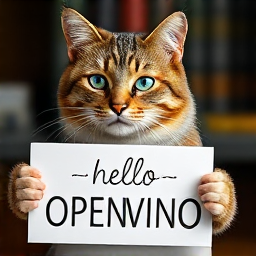

In [14]:
import torch

prompt = "A cat holding a sign that says hello OpenVINO"
image = ov_pipe(
    prompt, guidance_scale=0.0, num_inference_steps=4, max_sequence_length=256, generator=torch.Generator("cpu").manual_seed(0), height=256, width=256
).images[0]

image

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(ov_pipe)

# if you are launching remotely, specify server_name and server_port
#  demo.launch(server_name='your server name', server_port='server port in int')
# if you have any issue to launch on your platform, you can pass share=True to launch method:
# demo.launch(share=True)
# it creates a publicly shareable link for the interface. Read more in the docs: https://gradio.app/docs/
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)